In [2]:
import csv
import os
import sqlite3

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

In [3]:
from skyfield.api import load, wgs84

stations_url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle"
satellites = load.tle_file(stations_url)
print("Loaded", len(satellites), "satellites")
by_name = {sat.name: sat for sat in satellites}
satellite = by_name["STARLINK-1007"]

# year, month, day, hour, minute, second
ts = load.timescale()
t = ts.now()
a = satellite.at(t)
lat, lon = wgs84.latlon_of(a)
print("Latitude:", lat)
print("Longitude:", lon)

Loaded 4219 satellites
Latitude: 09deg 45' 01.9"
Longitude: 150deg 32' 27.6"


In [4]:
from common import calculate_visible_satellites

# garching coordinates
observer_latitude = 48.2489
observer_longitude = 11.6532
observer_elevation = 0

visible_satellites = calculate_visible_satellites(
    observer_latitude, observer_longitude, observer_elevation, distance_km=800
)

for sat, alt, az in visible_satellites:
    print(sat.name)
    # print(f"Satellite: {sat}")
    # print(f"Altitude: {alt.degrees} degrees")
    # print(f"Azimuth: {az.degrees} degrees")

STARLINK-1411
STARLINK-1502
STARLINK-3141
STARLINK-3663
STARLINK-5431
STARLINK-5392


In [5]:
def idplot(base, hops, _type, method, host=None):
    G = nx.Graph()
    g = {}
    for file in os.listdir(base):
        filename = os.fsdecode(file)
        if _type in filename and method in filename:
            with open(base + filename, "r") as csvfile:
                d = list(csv.reader(csvfile))
                for r in range(len(d) - (30 - hops)):
                    ip1 = d[r][2]
                    ip2 = d[r + 1][2]
                    effe = ["*", "ip"]
                    if ip1 not in effe and ip2 not in effe:
                        if ip1 not in g:
                            g[ip1] = []
                        if ip2 not in g[ip1]:
                            g[ip1].append(ip2)

    for k, v in g.items():
        G.add_node(k)
        for i in v:
            G.add_edge(k, i)

    return G


def draw(G):
    # _,degree = map(list, zip(*G.degree()))
    nx.draw_kamada_kawai(
        G,
        node_color=range(len(G.degree())),
        cmap=plt.cm.GnBu,
        # node_size=[(v * 500) + 1 for v in  degree],
        # with_labels=True,
    )

In [6]:
def cloud_draw(provider, hops, method):
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 2, 1)  # Define 3 rows, 2 column, Activate subplot 1.
    base = f"../idp-castellotti-data/new-traceroutes/{provider}/"
    plt.subplot(321).set_title(f"{provider} starlink {hops} hops {method}")
    G = idplot(base=base, hops=8, _type="starlink", method=method)
    draw(G)
    plt.subplot(322).set_title(f"{provider} normal {hops} hops {method} ")
    G = idplot(base=base, hops=hops, _type="normal", method=method)
    draw(G)
    plt.show()

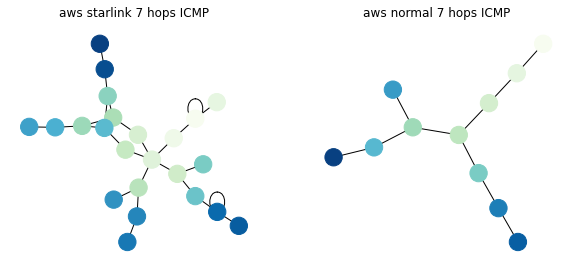

In [7]:
cloud_draw(provider="aws", hops=7, method="ICMP")

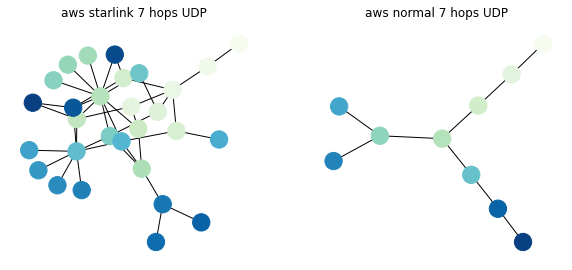

In [8]:
cloud_draw(provider="aws", hops=7, method="UDP")

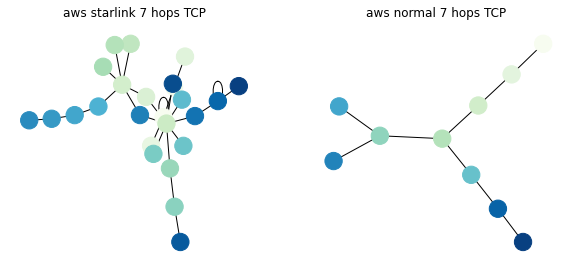

In [9]:
cloud_draw(provider="aws", hops=7, method="TCP")

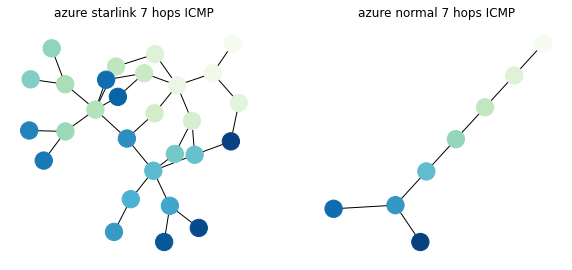

In [10]:
cloud_draw(provider="azure", hops=7, method="ICMP")

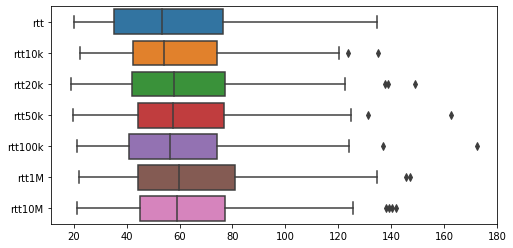

Text(0.5, 0, 'time (milliseconds)')

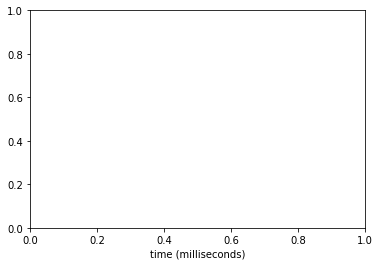

In [11]:
df0 = pd.read_csv("../idp-castellotti-data/ping-bw-normal.csv")
df1 = pd.read_csv("../idp-castellotti-data/ping-bw-10k.csv")
df2 = pd.read_csv("../idp-castellotti-data/ping-bw-20k.csv")
df3 = pd.read_csv("../idp-castellotti-data/ping-bw-50k.csv")
df4 = pd.read_csv("../idp-castellotti-data/ping-bw-100k.csv")
df5 = pd.read_csv("../idp-castellotti-data/ping-bw-1M.csv")
df6 = pd.read_csv("../idp-castellotti-data/ping-bw-10M.csv")
df = pd.concat([df0, df1, df2, df3, df4, df5, df6], axis=1).reindex(df1.index)
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df[
        [
            "rtt",
            # "pop_ping_latency_ms",
            "rtt10k",
            # "pop_ping_latency_ms10k",
            "rtt20k",
            # "pop_ping_latency_ms20k",
            "rtt50k",
            # "pop_ping_latency_ms50k",
            "rtt100k",
            # "pop_ping_latency_ms100k",
            "rtt1M",
            # "pop_ping_latency_ms1M",
            "rtt10M",
            # "pop_ping_latency_ms10M",
        ]
    ],
    orient="h",
)
# plt.savefig("tex/tumbeamer/pics/rtt-iperf-stress.png")
plt.show()
plt.xlabel("time (milliseconds)")

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.figure(figsize=(15, 10))
df = pd.read_csv("../idp-castellotti/large_file_download.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
df["bandwidth_bps"] = (df["bandwidth_bps"] - df["bandwidth_bps"].mean()) / df[
    "bandwidth_bps"
].std()
df = np.abs(np.fft.fft(df["bandwidth_bps"]))
# df=df[:5000]
print(df, np.abs(df))
ax = sns.lineplot(data=df[:200], dashes=True)
for i in range(4, 200, 15):
    ax.axvline(i, color="red", linestyle="--")

# plt.yscale("log")
# plt.title("donwloading hetzner test file")
# plt.show()

# while true; do wget -4 https://speed.hetzner.de/10GB.bin --report-speed=bits -O /dev/null; done
# sudo ip route add 88.198.248.254  via 192.168.1.1
# while true; do wget -4  http://ftp.de.debian.org/debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso --report-speed=bits -O /dev/null; done
# while true; do wget -4  http://mirror.netcologne.de/debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso --report-speed=bits -O /dev/null; done
# while true; do wget -4  http://mirror.23media.com//debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso --report-speed=bits -O /dev/null; done
# http://mirror.23media.com//debian-cd/current/amd64/iso-dvd/debian-12.0.0-amd64-DVD-1.iso

FileNotFoundError: [Errno 2] No such file or directory: '../idp-castellotti/large_file_download.csv'

<Figure size 1080x720 with 0 Axes>

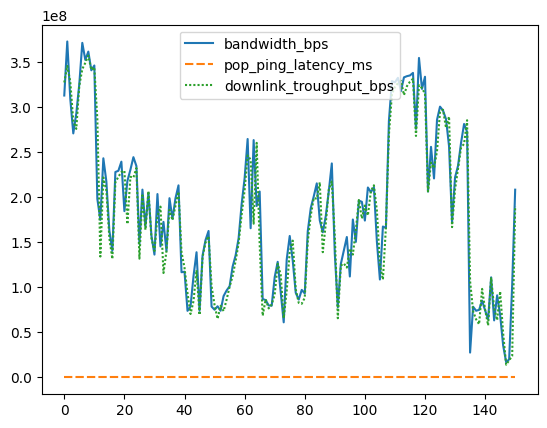

In [ ]:
df = pd.read_csv("../idp-castellotti/large_file_download_5parallel.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
plt.figure()


sns.lineplot(data=df[0:151], dashes=True)
for i in range(0, 151, 15):
    ax.axvline(i, color="red", linestyle="--")

plt.show()


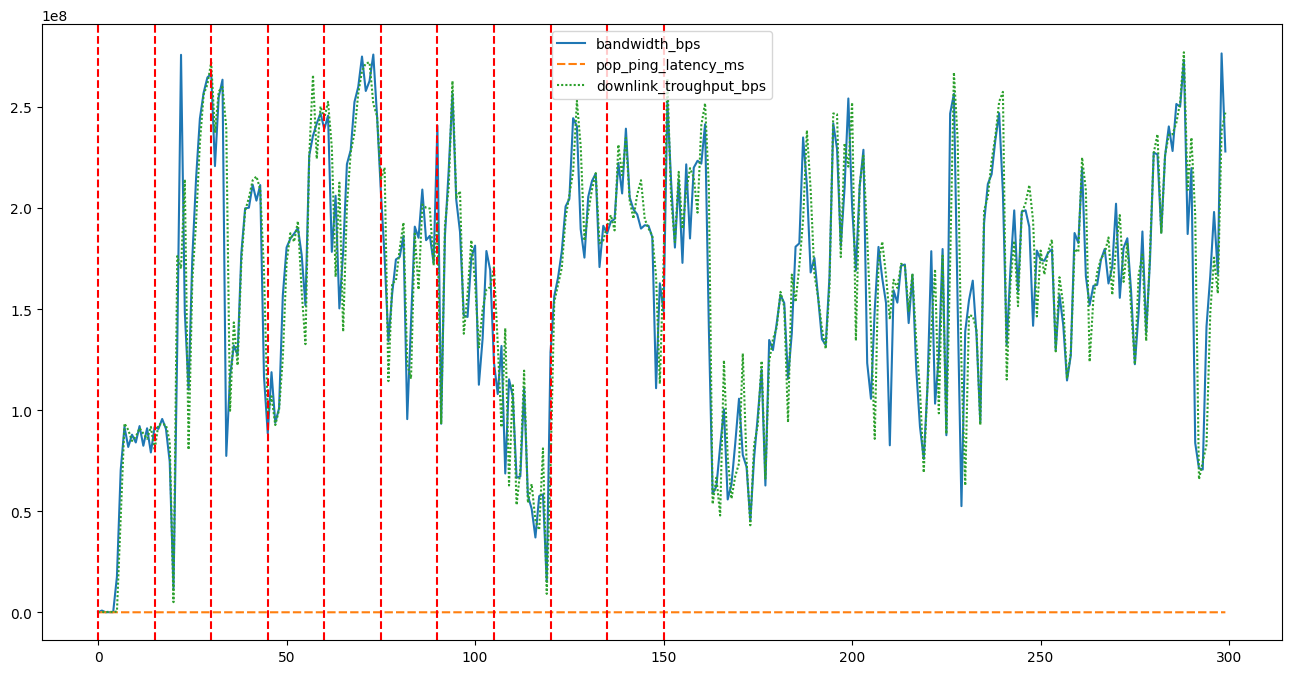

In [ ]:
df = pd.read_csv("../idp-castellotti/large_file_download_5parallel_obstruction_map.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s', origin='unix')
plt.figure(figsize=(16,8))
sns.lineplot(data=df[0:300], dashes=True)
for i in range(0, 151, 15):
    plt.axvline(i, color="red", linestyle="--")
plt.show()

<Figure size 640x480 with 0 Axes>

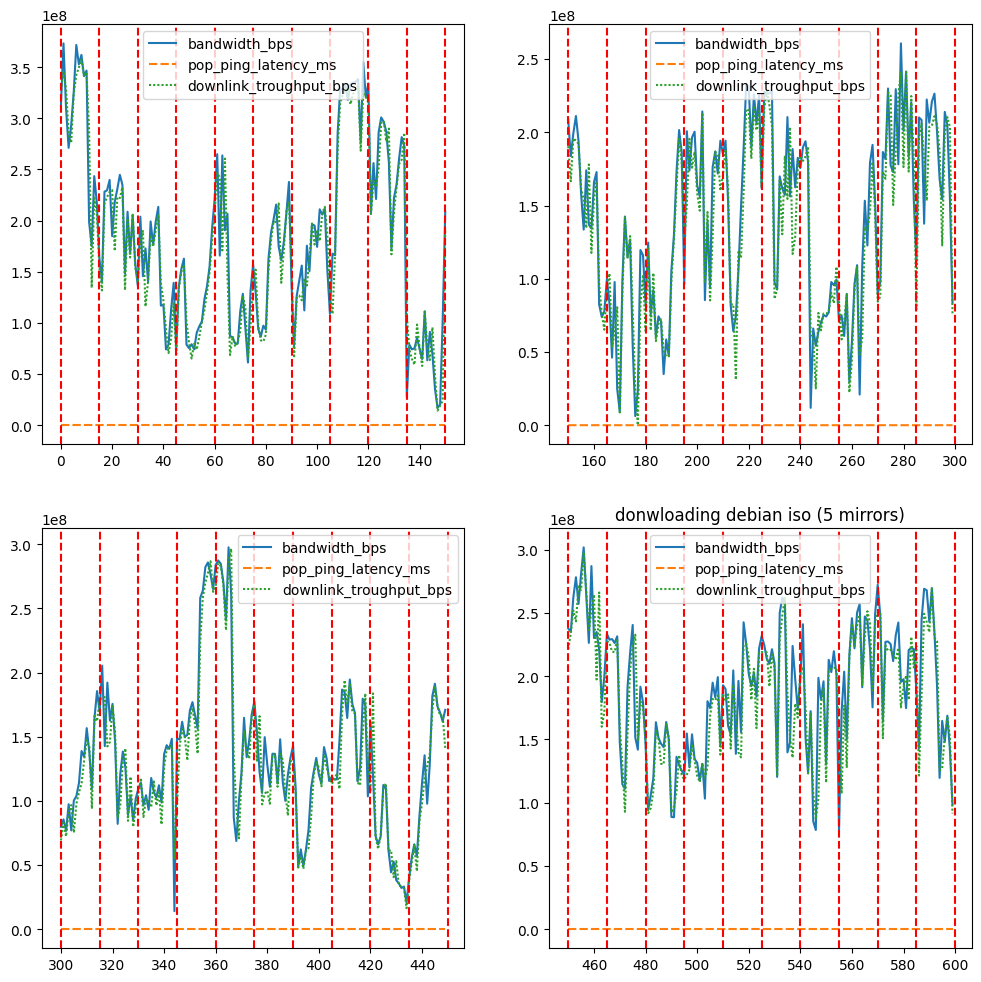

In [ ]:
df = pd.read_csv("../idp-castellotti/large_file_download_5parallel.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
plt.figure()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.title("donwloading debian iso (5 mirrors)")

ax = sns.lineplot(data=df[0:151], dashes=True, ax=axes[0, 0])
for i in range(0, 151, 15):
    ax.axvline(i, color="red", linestyle="--")

ax = sns.lineplot(data=df[150:300], dashes=True, ax=axes[0, 1])
for i in range(150, 301, 15):
    ax.axvline(i, color="red", linestyle="--")

ax = sns.lineplot(data=df[300:450], dashes=True, ax=axes[1, 0])
for i in range(300, 451, 15):
    ax.axvline(i, color="red", linestyle="--")

ax = sns.lineplot(data=df[450:600], dashes=True, ax=axes[1, 1])
for i in range(450, 601, 15):
    ax.axvline(i, color="red", linestyle="--")

plt.show()


# https://web.archive.org/web/20220320174537/https://ecfsapi.fcc.gov/file/1020316268311/Starlink%20Services%20LLC%20Application%20for%20ETC%20Designation.pdf
# while true; do wget -4 https://speed.hetzner.de/10GB.bin --report-speed=bits -O /dev/null; done
# sudo ip route add 88.198.248.254  via 192.168.1.1  add the entire /24
while true; do wget -4 http://mirror.de.leaseweb.net/debian-cd/12.1.0-live/amd64/iso-hybrid/debian-live-12.1.0-amd64-lxde.iso --report-speed=bits -O /dev/null; done
while true; do wget -4 http://mirror.nl.datapacket.com/debian-cd/12.1.0-live/amd64/iso-hybrid/debian-live-12.1.0-amd64-lxde.iso --report-speed=bits -O /dev/null; done
while true; do wget -4 http://ftp.uio.no/debian-cd/12.1.0-live/amd64/iso-hybrid/debian-live-12.1.0-amd64-lxde.iso --report-speed=bits -O /dev/null; done



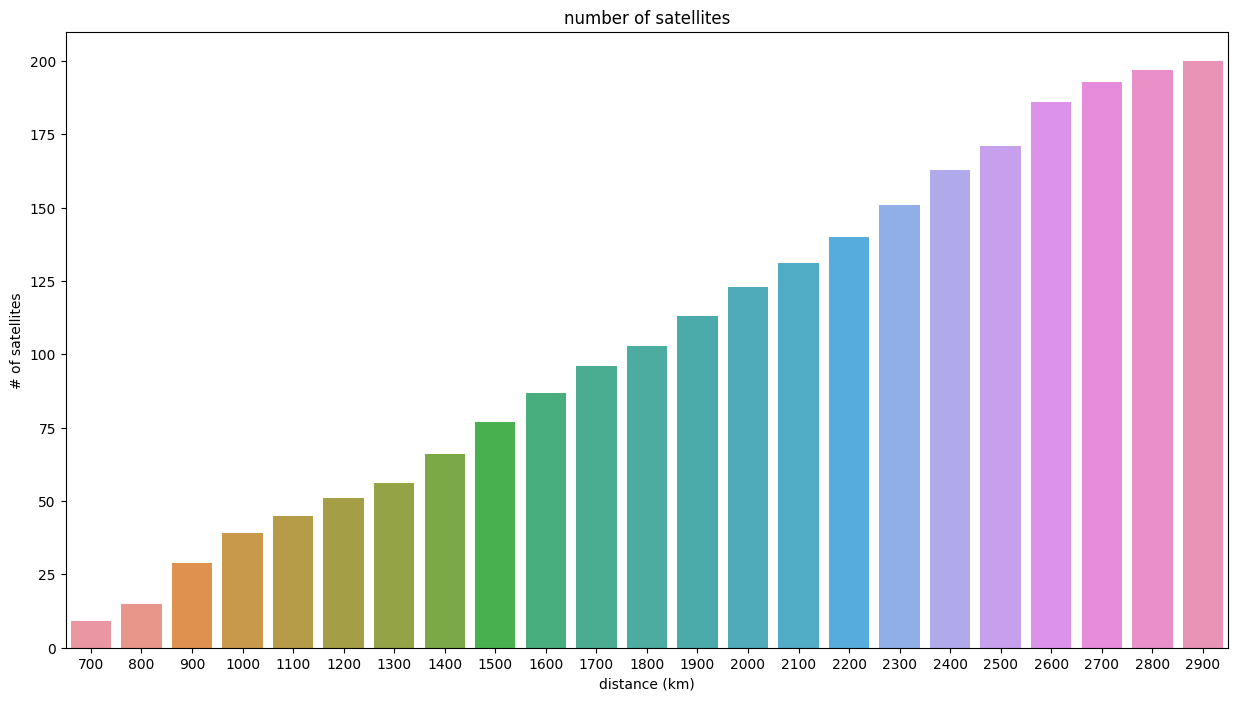

In [ ]:
df = pd.read_csv("../idp-castellotti-data/visible_satellites_variable_distance.csv")
plt.figure(figsize=(15, 8))
sns.countplot(x=df["distance"]).set_title("number of satellites")
plt.ylabel("# of satellites")
plt.xlabel("distance (km)")
plt.show()

In [ ]:
# df0 = pd.read_csv("/home/rc/idp-castellotti-data/hist2.csv")
# df1 = pd.read_csv("/home/rc/idp-castellotti-data/hist3.csv")
# df2 = pd.read_csv("/home/rc/idp-castellotti-data/history.csv")
# df = pd.concat([df0, df1, df2], axis=1).reindex(df1.index)
# df.head()
# df.to_csv("/home/rc/idp-castellotti-data/hist.csv")

In [ ]:
# df=pd.read_csv("/home/rc/idp-castellotti-data/hist.csv")
# df=df[:200]
# plt.figure(figsize=(20, 10))
# sns.lineplot(df)

In [ ]:
def split_non_consequtive(data):
    data = iter(data)
    val = next(data)
    chunk = []
    try:
        while True:
            chunk.append(val)
            val = next(data)
            if val[0] != chunk[-1][0] + 1:
                yield chunk
                chunk = []
    except StopIteration:
        if chunk:
            yield chunk

In [ ]:
import random
from collections import defaultdict
from datetime import datetime

cnx = sqlite3.connect("satellites.sqlite")
satellites = cnx.execute("SELECT * FROM satellites").fetchall()
sats = defaultdict(list)
for sat in satellites:
    sats[sat[3]].append([sat[1], round(sat[2]), sat[3]])

segments = defaultdict(list)
count = 0
for k in sats:
    if count == 10000:
        break
    count += 1
    for i in split_non_consequtive(sats[k]):
        segments[k].append(
            (datetime.fromtimestamp(i[0][1]), datetime.fromtimestamp(i[-1][1]))
        )
import pprint

# how long we see satellites for
# for s in random.choices(satellites,k=20):
#     sat=s[3]
#     current_sat=segments[sat]
#     print(sat)
#     for s in current_sat:
#         print(s[1]-s[0])

[]

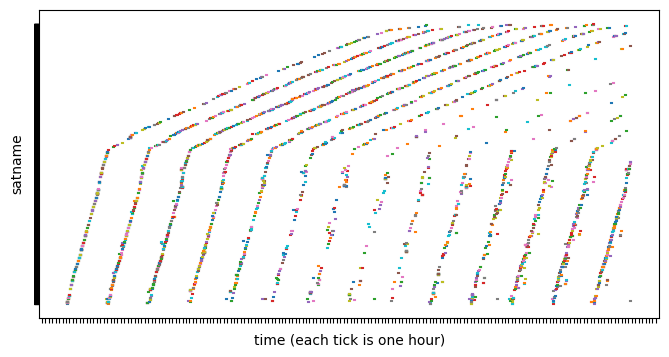

In [ ]:
import matplotlib.dates as mdates

# we need data in this format: https://stackoverflow.com/a/12291380
plt.figure(figsize=(8, 4))
for y in segments:
    for seg in segments[y]:
        plt.plot(seg, [y, y])
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.ylabel("satname")
plt.xlabel("time (each tick is one hour)")
# plt.title("visualizing how long satellites are visible for")
plt.savefig("tex/tumbeamer/pics/visualizing-how-long-satellites-are-visible-for.png")
plt.plot()

[]

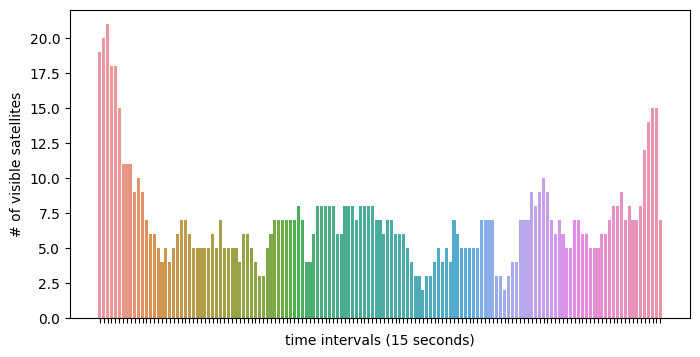

In [ ]:
cnx = sqlite3.connect("satellites.sqlite")
df = pd.read_sql("select * from satellites", cnx)
df = df[:1000]
df["timestamp"] = pd.to_datetime(df["ts"], unit="s")
plt.figure(figsize=(8, 4))

sns.countplot(df, x="relative_ts", dodge=False)
plt.xlabel("time intervals (15 seconds)")
plt.ylabel("# of visible satellites")
# plt.title('count of visible satellites in 15 seconds intervals')
plt.gca().axes.xaxis.set_ticklabels([])
plt.savefig("tex/tumbeamer/pics/count_visible_satellites.png")
plt.plot()

In [ ]:
import json
import numpy as np
from common import detect_handovers
plt.rcParams.update({'figure.max_open_warning': 0})
list=detect_handovers("/home/rc/idp-castellotti-data/raw_maps/")
for i,j in list:
    fig, ax = plt.subplots(1, 2,figsize=(12,7))
    map1 = json.load(open(i))
    map1 = map1["dishGetObstructionMap"]["snr"]
    map1 = np.array(map1).reshape(123, 123)
    map2 = json.load(open(j))
    map2 = map2["dishGetObstructionMap"]["snr"]
    map2 = np.array(map2).reshape(123, 123)
    ax[0].imshow(map1)
    ax[1].imshow(map2)
    plt.plot()

In [1]:
# working on correlating stuff

400    1690907705
Name: timestamp, dtype: int64


<Axes: >

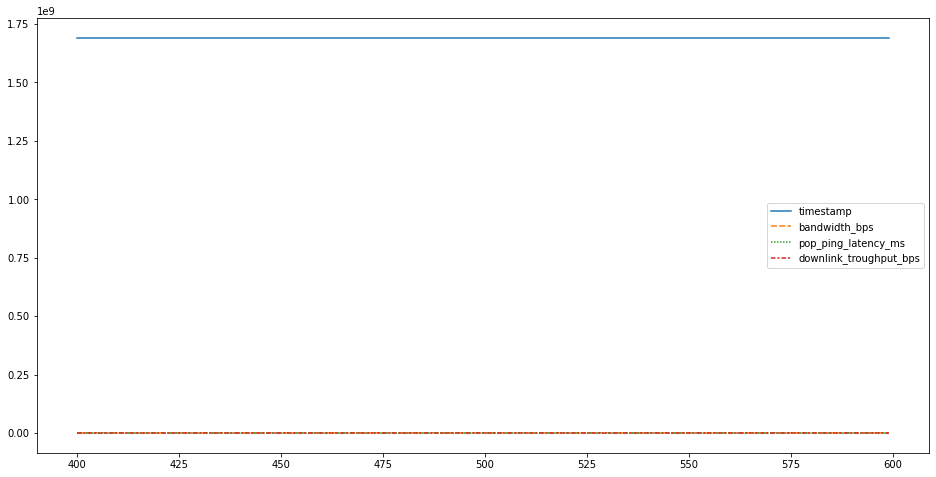

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("large_file_download_5parallel_obstruction_map.csv")
# df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s', origin='unix')
# print(df[400:401]["timestamp"])
plt.figure(figsize=(16,8))
sns.lineplot(data=df[400:600], dashes=True)
# for i in range(0, 151, 15):
#     plt.axvline(i, color="red", linestyle="--")
# plt.show()

In [4]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common import detect_handovers
plt.rcParams.update({'figure.max_open_warning': 0})
lista=detect_handovers("/home/rc/idp-castellotti/map-bw-stuff")
# df = pd.read_csv("bw.csv")
# df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s', origin="unix")
# print(df[400:401]["timestamp"])
# plt.figure(figsize=(16,8))
# sns.lineplot(data=df[:], x="timestamp",y="bandwidth_bps", dashes=True)
# print(list)

print(lista)
for i in lista:
    print(i)
    # plt.axvline(int(i[0]), color="red", linestyle="--")
# plt.show()
# for i,j in lista:
#     fig, ax = plt.subplots(1, 2,figsize=(12,7))
#     map1 = json.load(open(i))
#     map1 = map1["dishGetObstructionMap"]["snr"]
#     map1 = np.array(map1).reshape(123, 123)
#     map2 = json.load(open(j))
#     map2 = map2["dishGetObstructionMap"]["snr"]
#     map2 = np.array(map2).reshape(123, 123)
#     ax[0].imshow(map1)
#     ax[1].imshow(map2)
#     plt.plot()

[*] examining obstruction maps in interval: 1691072024 and 1691072350


['bw-stuff-viz/map-1691072111', 'bw-stuff-viz/map-1691072111', 'bw-stuff-viz/map-1691072111', 'bw-stuff-viz/map-1691072111', 'bw-stuff-viz/map-1691072126', 'bw-stuff-viz/map-1691072126', 'bw-stuff-viz/map-1691072126', 'bw-stuff-viz/map-1691072201']
bw-stuff-viz/map-1691072111
bw-stuff-viz/map-1691072111
bw-stuff-viz/map-1691072111
bw-stuff-viz/map-1691072111
bw-stuff-viz/map-1691072126
bw-stuff-viz/map-1691072126
bw-stuff-viz/map-1691072126
bw-stuff-viz/map-1691072201
